In [1]:
# !pip install pytrends
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta
from pytrends.request import TrendReq
import time
import pandas as pd
import matplotlib
import gtrend   


In [2]:
#print(plt.style.available)

In [3]:
plt.style.use('seaborn-v0_8-darkgrid')
matplotlib.rcParams['font.family'] = ['Heiti TC']
def rmax(maxrow: int=50):
    pd.set_option('display.max_rows', maxrow)

def cmax(maxcol: int=50):
    pd.set_option('display.max_columns', maxcol)

Setup the query terms and conditions

In [4]:
pytrend = TrendReq(hl='en-US')
keyword = 'insomnia'
start = '2017-01-01'
end = '2019-11-23'
geo='US'
cat=0
gprop=''

Acquire daily google trend data for over 9 month by concatenating multiple queries, and normalize(scaling) by the overlapping period (overlapping method)

In [5]:
overlapping = gtrend.get_daily_trend(pytrend, keyword, start, end, geo=geo, cat=cat, gprop=gprop, verbose=True, tz=0)

Fetching 'insomnia' for period:2019-02-27 2019-11-23
Fetching 'insomnia' for period:2018-09-11 2019-06-07
Normalize by overlapping period:2019-02-27 2019-06-07
Fetching 'insomnia' for period:2018-03-26 2018-12-20
Normalize by overlapping period:2018-09-11 2018-12-20
Fetching 'insomnia' for period:2017-10-08 2018-07-04
Normalize by overlapping period:2018-03-26 2018-07-04
Fetching 'insomnia' for period:2017-04-22 2018-01-16
Normalize by overlapping period:2017-10-08 2018-01-16
Fetching 'insomnia' for period:2016-11-04 2017-07-31
Normalize by overlapping period:2017-04-22 2017-07-31
Fetching 'insomnia' for period:2016-05-19 2017-02-12
Normalize by overlapping period:2016-11-04 2017-02-12


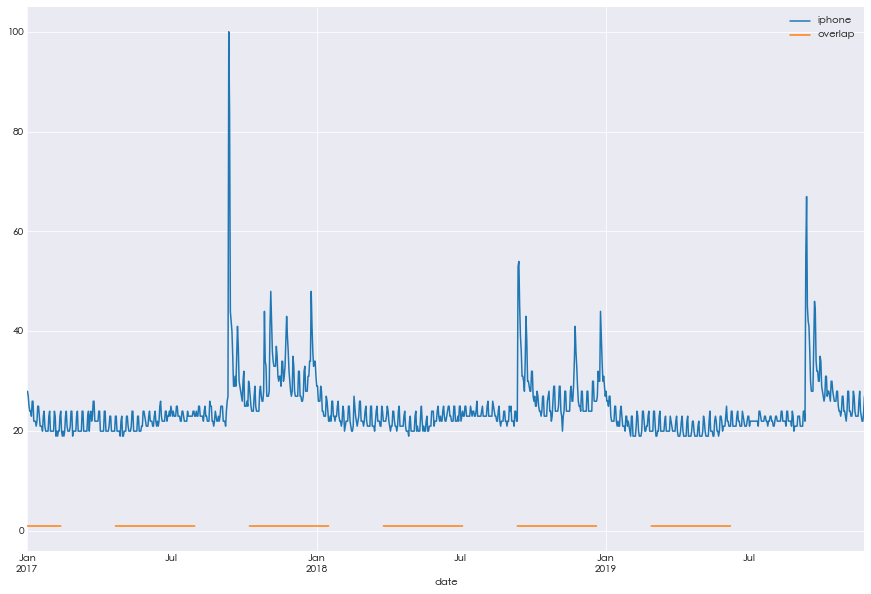

In [4]:
overlapping.plot(figsize=(15,10))

Acquire daily google trend data for over 9 month by concatenating multiple non-overlapping queries of 1-month, and normalize(scaling) by weekly trend value of the same period. (pytrends dailydata.py method)

In [5]:
from pytrends import dailydata

start_d = datetime.strptime(start, '%Y-%m-%d')
end_d = datetime.strptime(end, '%Y-%m-%d')
s_year = start_d.year
s_mon = start_d.month
e_year = end_d.year
e_mon = end_d.month

dailydata = dailydata.get_daily_data(word= keyword,
                 start_year= s_year,
                 start_mon= s_mon,
                 stop_year= e_year,
                 stop_mon= e_mon,
                 geo= geo,
                 verbose= False,
                 wait_time = 1.0)

Index(['iphone_unscaled', 'iphone_monthly', 'isPartial', 'scale', 'iphone'], dtype='object')


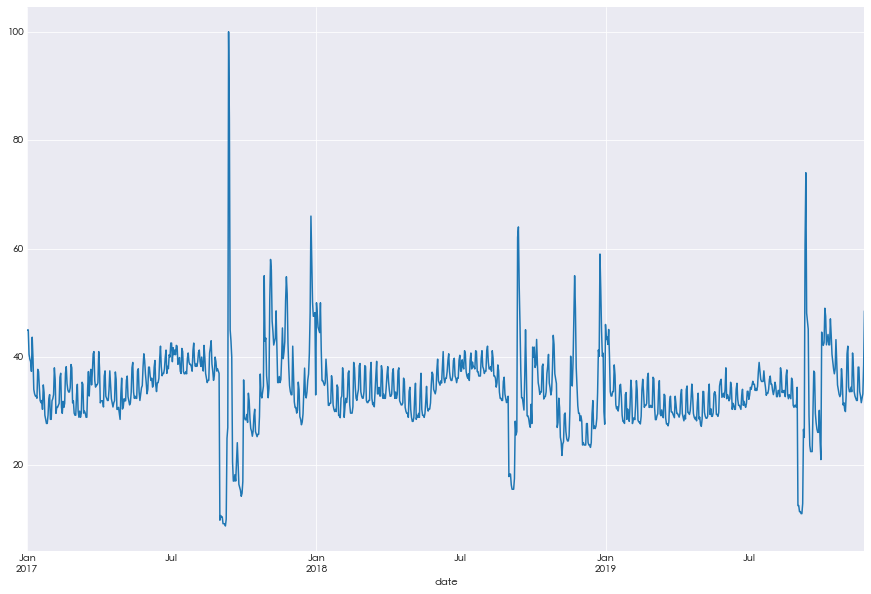

In [6]:
print(dailydata.columns)
dailydata[f'{keyword}'].plot(figsize=(15,10))

The weekly trend data might be a reference for comparing above normalization methods. For query period between 269 days (~9months) and 5 years, google trend will return weely data. 
To have comparable axis scale, the weekly data is interpolated to obtain daily data. 

In [7]:
tf = start_d.strftime('%Y-%m-%d')+' '+end_d.strftime('%Y-%m-%d')
pytrend.build_payload(kw_list=[keyword], cat=cat, geo=geo, gprop=gprop, timeframe=tf)
week = pytrend.interest_over_time()
week_interp = week.resample('D').mean()
week_interp[f'{keyword}'] = week_interp[f'{keyword}'].interpolate()

In [8]:
week_interp.drop(columns='isPartial', inplace=True)

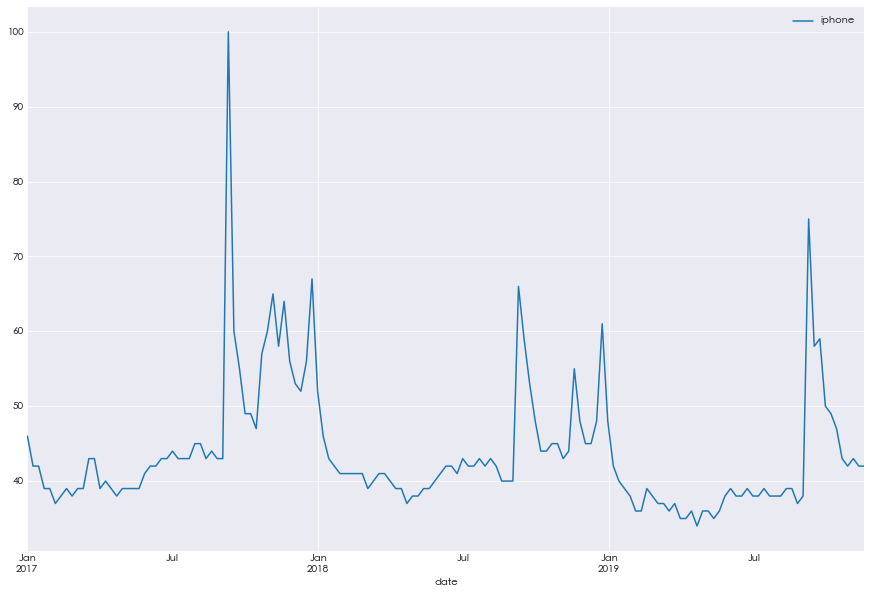

In [9]:
week_interp.plot(figsize=(15,10))

For better visual comparison, let's put all 3 dataset together.

In [10]:
overlapping.loc[:,keyword]

date
2017-01-01    28.0
2017-01-02    27.0
2017-01-03    25.0
2017-01-04    24.0
2017-01-05    24.0
              ... 
2019-11-19    23.0
2019-11-20    22.0
2019-11-21    22.0
2019-11-22    24.0
2019-11-23    27.0
Freq: D, Name: iphone, Length: 1057, dtype: float64

In [11]:
overlapping.columns

Index(['iphone', 'overlap'], dtype='object')

In [12]:
combined = pd.concat([overlapping, dailydata.loc[:,keyword], week_interp], axis=1)

In [34]:
combined.tail(20)

overlapping method  overlap period  dailydata method  weekly data
date                                                                         
2019-11-05                24.0             NaN             33.60    42.714286
2019-11-06                23.0             NaN             33.60    42.571429
2019-11-07                23.0             NaN             34.44    42.428571
2019-11-08                24.0             NaN             33.60    42.285714
2019-11-09                28.0             NaN             40.74    42.142857
2019-11-10                27.0             NaN             38.13    42.000000
2019-11-11                24.0             NaN             33.62    42.000000
2019-11-12                23.0             NaN             32.80    42.000000
2019-11-13                23.0             NaN             32.39    42.000000
2019-11-14                23.0             NaN             31.98    42.000000
2019-11-15                23.0             NaN             31.98    42.000000
2019-11-16                26.0             NaN             38.13    42.000000
2019-11-17                28.0             NaN             38.13    42.000000
2019-11-18                24.0             NaN             33.62          NaN
2019-11-19                23.0             NaN             32.80          NaN
2019-11-20                22.0             NaN             31.57          NaN
2019-11-21                22.0             NaN             32.39          NaN
2019-11-22                24.0             NaN             33.21          NaN
2019-11-23                27.0             NaN             38.54          NaN
2019-11-24                 NaN             NaN             48.51          NaN

In [13]:
combined.columns = ['overlapping method','overlap period', 'dailydata method', 'weekly data']
combined = combined.resample('D').mean()

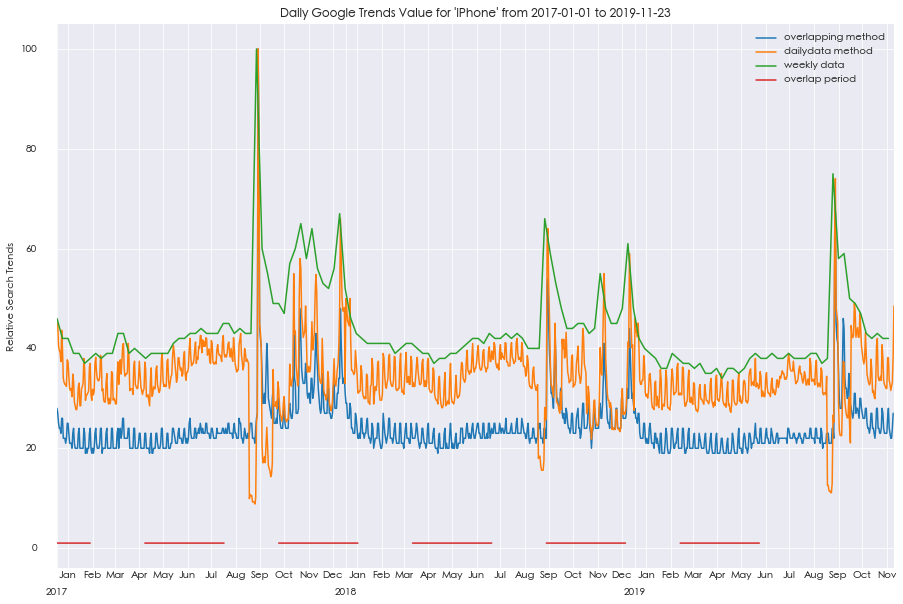

In [14]:
import matplotlib.dates as mdates
from cycler import cycler
from matplotlib.cm import get_cmap

combined2 = combined.iloc[:, [0,2,3,1]]
combined2.index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in combined2.index]
# c = ['royalblue', 'darkorange', 'limegreen', 'salmon']
# colors = plt.cm.Paired(np.linspace(0,1,4)) # This returns RGBA; convert:
c = []
for i in range(0,4):
    c.append(matplotlib.colors.rgb2hex(plt.cm.tab10(i)))
ax = combined2.plot(figsize=(15,10), color=c)
# set line colors
# c = plt.cm.hot(np.linspace(0,1,4))
# ax.set_prop_cycle(cycler('color', c))
# ax.set_prop_cycle(color=colors)
# ax.set_prop_cycle('color',plt.cm.Spectral(np.linspace(0,1,30)))
# set monthly locator
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

ax.tick_params(direction='out', pad=20)
# set font and rotation for date tick labels
# plt.gcf().autofmt_xdate()
ax.xaxis.grid(True, which='minor')

plt.ylabel('Relative Search Trends')
# plt.xlabel('Date')
plt.title('Daily Google Trends Value for \'iPhone\' from '+start+' to '+end)
# plt.set_cmap('Pastel2')

plt.show()


Use plotly to have better visualization

In [15]:
# ax.get_lines()[0].get_color(), ax.get_lines()[1].get_color(), ax.get_lines()[2].get_color(), ax.get_lines()[3].get_color()

In [16]:
# combined['overlap period'].fillna(value='0', inplace=True)
combined.tail(20)

overlapping method  overlap period  dailydata method  weekly data
date                                                                         
2019-11-05                24.0             NaN             33.60    42.714286
2019-11-06                23.0             NaN             33.60    42.571429
2019-11-07                23.0             NaN             34.44    42.428571
2019-11-08                24.0             NaN             33.60    42.285714
2019-11-09                28.0             NaN             40.74    42.142857
2019-11-10                27.0             NaN             38.13    42.000000
2019-11-11                24.0             NaN             33.62    42.000000
2019-11-12                23.0             NaN             32.80    42.000000
2019-11-13                23.0             NaN             32.39    42.000000
2019-11-14                23.0             NaN             31.98    42.000000
2019-11-15                23.0             NaN             31.98    42.000000
2019-11-16                26.0             NaN             38.13    42.000000
2019-11-17                28.0             NaN             38.13    42.000000
2019-11-18                24.0             NaN             33.62          NaN
2019-11-19                23.0             NaN             32.80          NaN
2019-11-20                22.0             NaN             31.57          NaN
2019-11-21                22.0             NaN             32.39          NaN
2019-11-22                24.0             NaN             33.21          NaN
2019-11-23                27.0             NaN             38.54          NaN
2019-11-24                 NaN             NaN             48.51          NaN

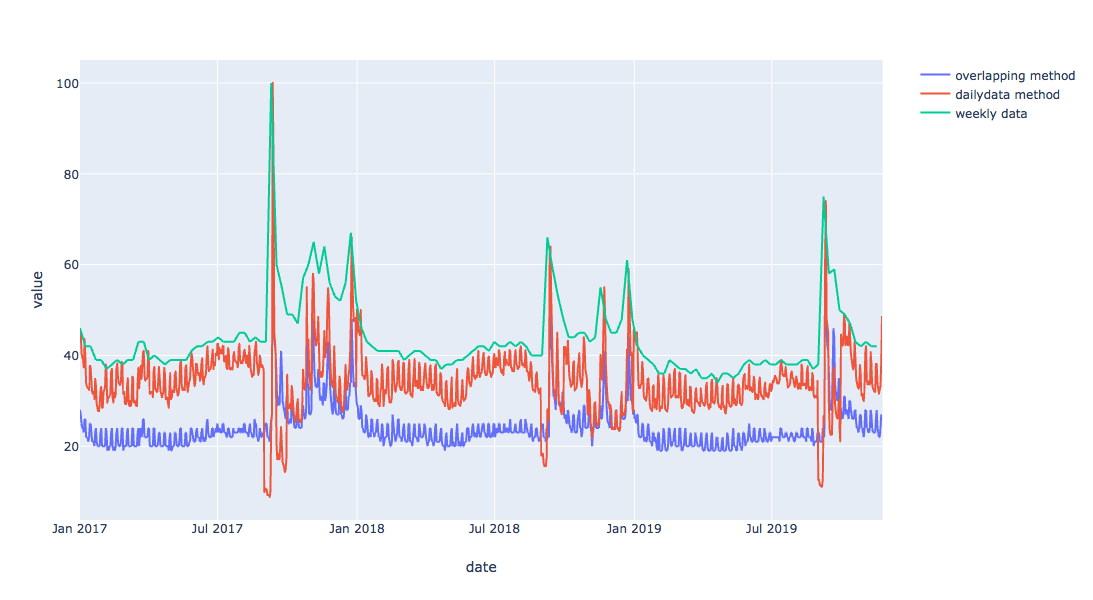

In [17]:
combined_m = pd.melt(combined.reset_index().drop(columns='overlap period'), id_vars='date')
import plotly.express as px
import plotly.graph_objects as go

fig = px.line(combined_m, x='date', y='value', color='variable').for_each_trace(lambda t: t.update(name=t.name.replace("variable=","")))

fig.update_layout(xaxis = dict(
                    tickmode = 'auto',
#                     tick0 = '2017-01-15',  # start tick on the middle of each month
#                     dtick = (28*86400000.0) # tick spaced for every 28 days
#                     dtick = 'M1' # tick spaced for every 1 month


                )
                )

fig.show()

Let's focus on a shorter period, such as 2017 Jul to 2017 Dec where the trend data varies a lot and 3 methods gave quite different values. In this case, we can even fetch the 'real' daily data directly from google trend (period less then 9 months) without doing any scaling/processing for comparison. 

In [18]:
p_start = '2017-07-01'
p_end = '2017-12-31'
# p_start_d = datetime.strptime(p_start, '%Y-%m-%d')
# p_end_d = datetime.strptime(p_end, '%Y-%m-%d')
tf = p_start+' '+p_end
geo='US'
pytrend.build_payload(kw_list=[keyword], cat=cat, geo=geo, gprop=gprop, timeframe=tf)
daily_real = pytrend.interest_over_time()

Correct the time zone difference 

In [20]:
combined_period = combined.loc[p_start:p_end]
combined_period  = pd.concat([combined_period,daily_real], axis=1)
combined_period.drop(columns=['isPartial','overlap period'], inplace=True)
combined_period.columns = ['overlapping method', 'dailydata method', 'weekly data', 'original data']

In [21]:
c = []
for i in range(0,7):
    c.append(matplotlib.colors.rgb2hex(plt.cm.tab10(i)))
c

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

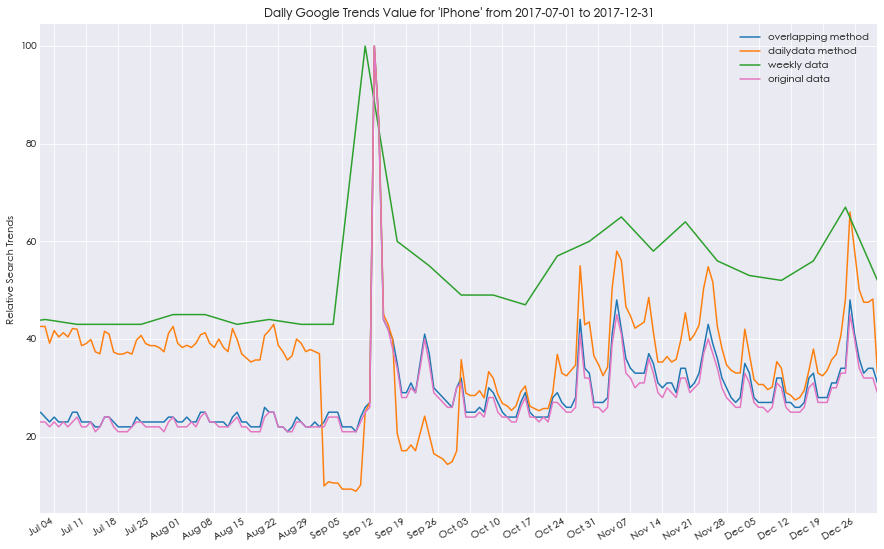

In [22]:
# combined_period.plot(figsize=(15,10))
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU

combined2 = combined_period.copy()
combined2.index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in combined2.index]
c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#e377c2']
ax = combined2.plot(figsize=(15,10), color=c)
# set weekday locator
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=TU))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()

plt.ylabel('Relative Search Trends')
plt.xlabel(None)
plt.title('Daily Google Trends Value for \'iPhone\' from '+p_start+' to '+p_end)


plt.show()

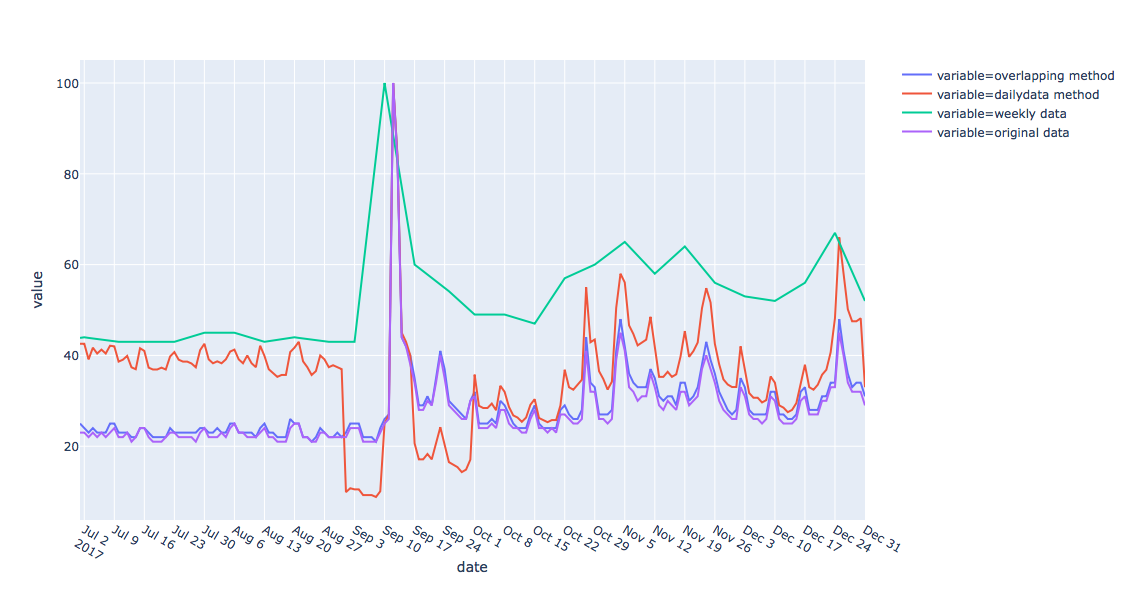

In [24]:
period_m = pd.melt(combined_period.reset_index(), id_vars='date')

fig = px.line(period_m, x='date', y='value', color='variable')
fig.update_layout(xaxis = dict(
                    tickmode = 'linear',
                    tick0 = '2017-07-02',  # start on sunday
                    dtick = (7*86400000.0) # tick spaced for every 7 days
                )
                )
fig.show()

# xaxis = {
#    'tickformat': '%Y-%m-%d',
#    'tickmode': 'auto',
#    'nticks': value, [where value is the max # of ticks]
#    'tick0': value, [where value is the first tick]
#    'dtick': value [where value is the step between ticks]
# }

In [25]:
# !pip install yfinance
import yfinance as yf

ticker = yf.Ticker("AAPL")
print(ticker)
# ticker.info
aapl = ticker.history(start=start, end=end)

yfinance.Ticker object <AAPL>


In [27]:
combined_stock = pd.concat([combined, aapl.Close], axis=1)
combined_stock.drop(columns=['dailydata method', 'overlap period'], inplace=True)

In [28]:
combined_stock.columns = ['daily trends', 'weekly trends', 'AAPL stock price']

In [36]:
combined.drop(index=date(2019,11,24), inplace=True)
combined.tail(20)

overlapping method  overlap period  dailydata method  weekly data
date                                                                         
2019-11-04                24.0             NaN             34.44    42.857143
2019-11-05                24.0             NaN             33.60    42.714286
2019-11-06                23.0             NaN             33.60    42.571429
2019-11-07                23.0             NaN             34.44    42.428571
2019-11-08                24.0             NaN             33.60    42.285714
2019-11-09                28.0             NaN             40.74    42.142857
2019-11-10                27.0             NaN             38.13    42.000000
2019-11-11                24.0             NaN             33.62    42.000000
2019-11-12                23.0             NaN             32.80    42.000000
2019-11-13                23.0             NaN             32.39    42.000000
2019-11-14                23.0             NaN             31.98    42.000000
2019-11-15                23.0             NaN             31.98    42.000000
2019-11-16                26.0             NaN             38.13    42.000000
2019-11-17                28.0             NaN             38.13    42.000000
2019-11-18                24.0             NaN             33.62          NaN
2019-11-19                23.0             NaN             32.80          NaN
2019-11-20                22.0             NaN             31.57          NaN
2019-11-21                22.0             NaN             32.39          NaN
2019-11-22                24.0             NaN             33.21          NaN
2019-11-23                27.0             NaN             38.54          NaN

In [37]:
df_m = pd.melt(combined_stock.reset_index(), id_vars='index')

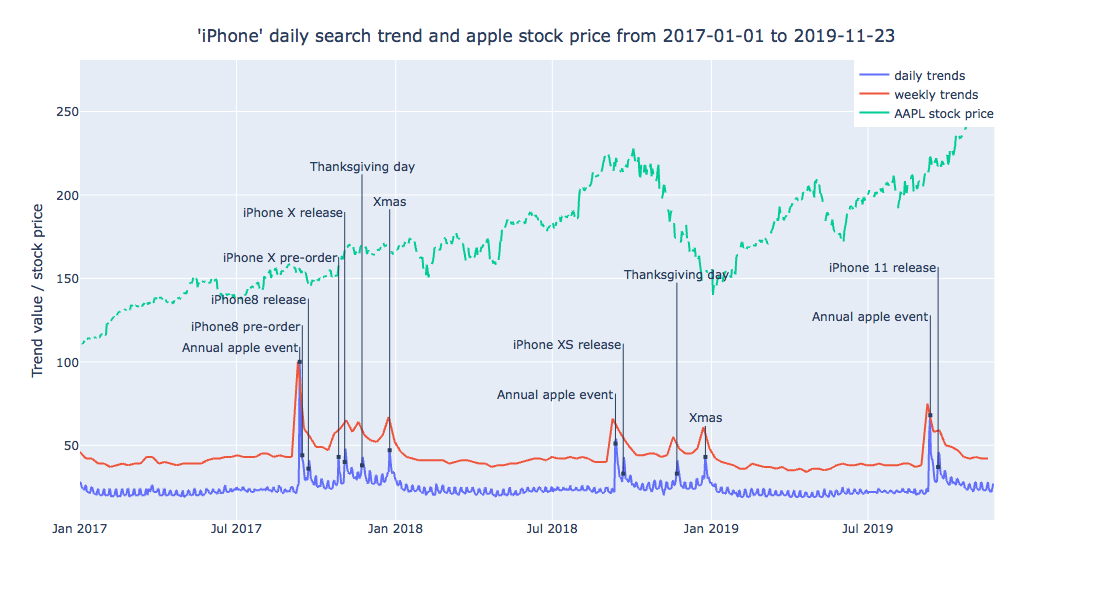

In [52]:
fig = px.line(df_m, x='index', y='value', color='variable').for_each_trace(lambda t: t.update(name=t.name.replace("variable=","")))


fig.update_layout(xaxis = dict(
                    tickmode = 'auto'
#                     tickmode = 'linear',
#                     tick0 = '2017-07-12',  # start on sunday
#                     dtick = 'M1',
#                     tickformat = '%b %Y'
                    ) # 
                )

fig.add_annotation(
    go.layout.Annotation(
            x='2017-09-12',
            y=100,
            text="Annual apple event",
            xanchor='right',
            ax=0,
            ay=-15
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2017-09-15',
            y=44,
            text="iPhone8 pre-order",
            xanchor='right',
            ax=0,
            ay=-130
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2017-09-22',
            y=36,
            text="iPhone8 release", 
            xanchor='right',
            ax=0, 
            ay=-170
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2017-10-27',
            y=43,
            text="iPhone X pre-order",
            xanchor='right',
            ax=0,
            ay=-200
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2017-11-03',
            y=40,
            text="iPhone X release",
            xanchor='right',
            ax=0,
            ay=-250
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2017-11-23',
            y=38,
            text="Thanksgiving day",
#             xanchor='right',
            ax=0,
            ay=-300
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2017-12-25',
            y=47,
            text="Xmas",
#             xanchor='right',
            ax=0,
            ay=-250
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2018-09-12',
            y=51,
            text="Annual apple event",
            xanchor='right',
            ax=0,
            ay=-50
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2018-09-21',
            y=33,
            text="iPhone XS release",
            xanchor='right',
            ax=0,
            ay=-130
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2018-11-22',
            y=33,
            text="Thanksgiving day",
#             xanchor='right',
            ax=0,
            ay=-200
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2018-12-25',
            y=43,
            text="Xmas",
#             xanchor='right',
            ax=0,
            ay=-40
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2019-09-11',
            y=68,
            text="Annual apple event",
            xanchor='right',
            ax=0,
            ay=-100
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2019-09-20',
            y=37,
            text="iPhone 11 release",
            xanchor='right',
            ax=0,
            ay=-200
    )
)

fig.update_annotations(dict(
            xref="x",
            yref="y",
            showarrow=True,
            arrowhead=7
))

fig.update_layout(
    title={
        'text': "\'iPhone\' daily search trend and apple stock price from "+start+" to "+end,
#         'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title=None,
    yaxis_title="Trend value / stock price",
    legend=go.layout.Legend(
        x=0.83,
        y=1,
        traceorder="normal",
#         font=dict(
#             family="sans-serif",
#             size=12,
#             color="black"
#         ),
#         bgcolor="LightSteelBlue",
#         bordercolor="Black",
#         borderwidth=2
    )
#     font=dict(
#         family="Courier New, monospace",
#         size=18,
#         color="#7f7f7f"
#     )
)

fig.show()

# xaxis = {
#    'tickformat': '%Y-%m-%d',
#    'tickmode': 'auto',
#    'nticks': value, [where value is the max # of ticks]
#    'tick0': value, [where value is the first tick]
#    'dtick': value [where value is the step between ticks]
# }